In [144]:
## !pip install scikit-image==0.19.3
import os
import time
import random
import joblib
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import cv2
from skimage import feature as ft
import skimage
print(skimage.__version__)

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb


import warnings
warnings.filterwarnings("ignore")

0.23.2


In [145]:
data_dir = "C:/Users/ymh33/Desktop/MachineLearning/ClassDesign/test1/new_plant/new_plant/"#训练与测试集根目录

class_names = os.listdir(data_dir + "train/")
classes_dict = dict()
#类别字典
for i, name in enumerate(class_names):
    classes_dict[name] = i
classes_dict

{'Black-grass': 0,
 'Common wheat': 1,
 'Loose Silky-bent': 2,
 'Scentless Mayweed': 3,
 'Sugar beet': 4}

# 图像预处理函数

## equalize() 直方图均衡

In [146]:
# 直方图均衡化
def equalize(img):
    """Parameter `img` is read by cv2.imread(), so it is in BGR mode"""
    
    b, g, r = cv2.split(img)    # RGB图像读取
    
    #RGB分别进行直方图均衡化
    b = cv2.equalizeHist(b)
    g = cv2.equalizeHist(g)    
    r = cv2.equalizeHist(r)
    
    img_equalized = cv2.merge((b, g, r))
    
    return img_equalized

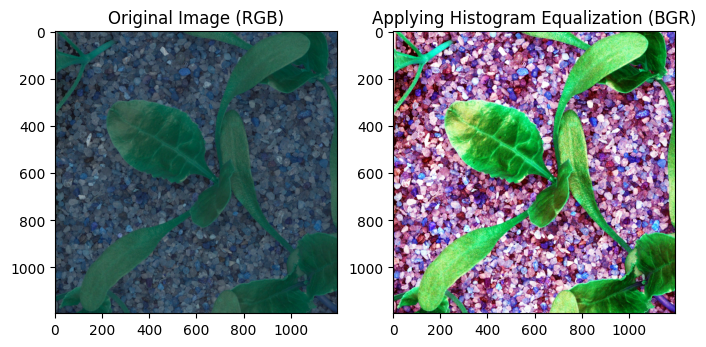

In [147]:
## TEST

img_bgr_try = cv2.imread(data_dir + "train/Sugar beet/u.png")
img_equalized = equalize(img_bgr_try)

fig  = plt.figure(figsize=(8, 16))
ax1 = plt.subplot(121)
ax1.imshow(img_bgr_try)
ax1.set_title("Original Image (RGB)")
ax2 = plt.subplot(122)
ax2.imshow(img_equalized)
ax2.set_title("Applying Histogram Equalization (BGR)")
plt.show()

## extract_seedling():特征提取（绿色）

In [148]:
def extract_seedling(img):
    """Parameter `img` is read by cv2.imread(), so it is in BGR mode"""
    
    # 绿色区间
    green_lower = np.array([35, 43, 46], dtype="uint8")   # 下界
    green_upper = np.array([90, 255, 255], dtype="uint8") # 上界
    
    # 高斯滤波
    img_gaussed = cv2.GaussianBlur(img, (3, 3), 0)
    img_gaussed = cv2.cvtColor(img_gaussed, cv2.COLOR_BGR2HSV)
    
    # 二值化处理创建掩码
    mask = cv2.inRange(img_gaussed, green_lower, green_upper)
    
    img_extracted = cv2.bitwise_and(img, img, mask=mask)
    
    return img_extracted

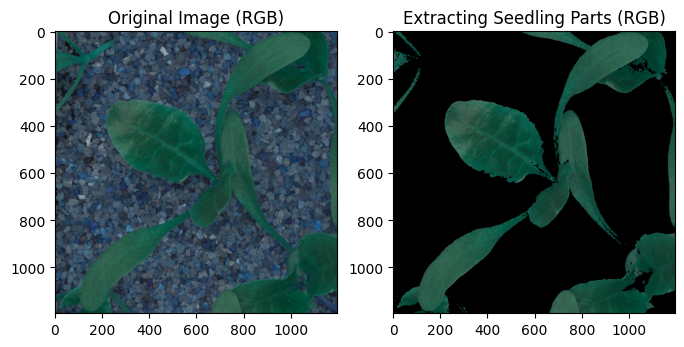

In [149]:
## TEST

img_bgr_try = cv2.imread(data_dir + "train/Sugar beet/u.png")
img_extracted = extract_seedling(img_bgr_try)

fig  = plt.figure(figsize=(8, 16))
ax1 = plt.subplot(121)
ax1.imshow(img_bgr_try)           
ax1.set_title("Original Image (RGB)")
ax2 = plt.subplot(122)
ax2.imshow(img_extracted)
ax2.set_title("Extracting Seedling Parts (RGB)")
plt.show()

## 图像预处理操作

In [150]:
#训练集处理
def preprocessing_imgs(file_dir):
    
    
    images_list = []
    labels_list = []
    
    classes = os.listdir(file_dir)
    # print(classes)
    
    for cls in classes:
        img_names = os.listdir(file_dir + cls)
        # cls_folder = train_preprocessed_dir + cls
        # if not os.path.exists(cls_folder):
        #     os.makedirs(cls_folder)        # Create class folder if it does not exist
            
        for img_name in img_names:
            img_bgr = cv2.imread(file_dir + cls + '/' + img_name)
            img_equalized = equalize(img_bgr)
            img_seedling = extract_seedling(img_equalized)
            
            images_list.append(img_seedling)
            labels_list.append(classes_dict[cls])

    return images_list, labels_list

In [151]:
images_list, labels_list = preprocessing_imgs(data_dir + "train/")
num_per_class = Counter(labels_list)
num_per_class

Counter({0: 100, 1: 100, 2: 100, 3: 100, 4: 100})

In [152]:
#测试集处理
def preprocessing_test_imgs(file_dir):
    
    
    images_list = []
    img_names = os.listdir(file_dir + "test/")
    for img_name in img_names:
        img_bgr = cv2.imread(file_dir + 'test/' + img_name)
        img_equalized = equalize(img_bgr)
        img_seedling = extract_seedling(img_equalized)

        images_list.append(img_seedling)
    return images_list

In [153]:
imgs_list_test = preprocessing_test_imgs(data_dir)

In [154]:
#将两个处理过的数组拼接在一起以便于进行接下来的特征提取
# all_images = np.concatenate((images_list, imgs_list_test))
all_images=images_list+imgs_list_test
#！！！进行特征训练之前一定要把训练集跟测试计划分开！！！

In [155]:
all_label = np.array(labels_list)

print(f'图像数量: {len(images_list)}')                 # 500
print(f'第一张图片的shape: {images_list[0].shape}')    # (w, h, 3)
print(f'label数量: {all_label.shape[0]}')              # 500

图像数量: 500
第一张图片的shape: (334, 334, 3)
label数量: 500


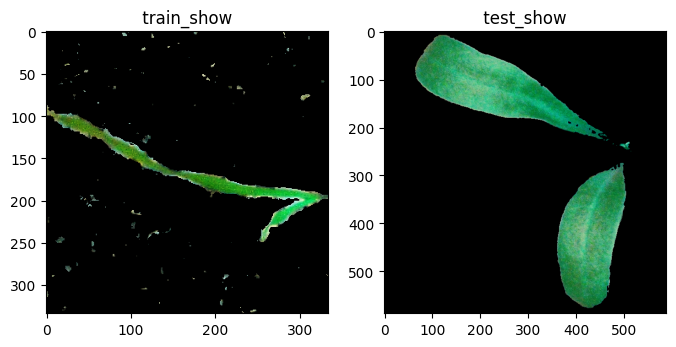

In [156]:
fig  = plt.figure(figsize=(8, 16))
ax1 = plt.subplot(121)
ax1.imshow(images_list[0])
ax1.set_title(" train_show ")
ax2 = plt.subplot(122)
ax2.imshow(imgs_list_test[0])
ax2.set_title(" test_show ")
plt.show()

## resize_imgs()：图像大小重塑

In [157]:
def resize_imgs(all_images):
    """Resize images into the shape as (128, 128, 3) to ensure that they have the same shape."""
    
    imgs_list = []
    for image in all_images:
        image = cv2.resize(image, (128, 128)) 
        imgs_list.append(image)
    return imgs_list

# 特征提取与处理

### 缺失值处理

In [158]:
# 填充缺失值
def fill_missing(feature):
    feature_df = pd.DataFrame(feature)      # 转为 DataFrame 格式，才能使用 fillna 函数
    feature_df_fill = feature_df.fillna(0)  # 将缺失值部分填充0
    
    return np.array(feature_df_fill)        # 返回array格式

### 标准化

In [159]:
# 标准化
def normalize(feature):
    scaler = StandardScaler()
    scaler.fit(feature)
    feature_normal = scaler.transform(feature)
    
    return feature_normal

### dimensionalityReduction()：特征提取


由于提取出的 HOG，LBP 的特征维数很大，如果直接使用全部的特征矩阵作为训练集特征，训练速度很慢，且他们作为特征的占比过多，会影响到训练效果，导致准确率不高，因此需要使用主成分分析（PCA）对特征进行降维。

其中 `estimator.explained_variance_ratio_` 表示降维后每个维度能代表原先特征的占比，遍历并对其累加输出，方便确定一个好的降维维度数，使其维度不太多且能代表原先特征的较高占比，尽量减少降维所造成的特征损失。

In [160]:
# PCA(Principal Component Analysis) 降维
def dimensionalityReduction(feature, n=100, is_whiten=False, is_show=True):
    estimator = PCA(n_components=n, whiten=is_whiten)
    pca_feature = estimator.fit_transform(feature)
    
    sum = 0
    for ratio in estimator.explained_variance_ratio_:
        sum += ratio
        if is_show:
            print(sum)
    
    print('降维后特征矩阵shape为:', pca_feature.shape)
    print('主成分比例为:', sum)
    
    return pca_feature

### save_feature()：特征保存函数

In [161]:
print(os.getcwd())

os.makedirs("./save_features", exist_ok=True)

c:\Users\ymh33\Desktop\MachineLearning\ClassDesign


In [162]:
feature_dir = "./save_features/"

# 将提取出的特征数组（二维）保存到npy文件中
def save_feature(feature, fileName):
    np.save(feature_dir + fileName + '.npy', feature, allow_pickle=True)
    
    print(fileName + '.npy', '文件已生成！')

### read_feature()：读取保存的特征文件

In [163]:
feature_dir = "./save_features/"

# 读取之前保存好的 feature 文件，返回特征矩阵（二维数组）
def read_feature(fileName):
    feature = np.load(feature_dir + fileName + '.npy', allow_pickle=True)
    print('已读取', fileName, '文件！\t shape = ', feature.shape)

    return feature

## SIFT+BOW特征提取

In [164]:
def sift_feature(all_images):
    """Extract SIFT feature of the image"""
    
    feature_sift_list = []  # SIFT特征向量列表
    
    # sift = cv2.xfeatures2d.SIFT_create()   # old-version cv2
    sift = cv2.SIFT_create()
    
    for i in tqdm(range(len(all_images))):
        image = cv2.cvtColor(all_images[i], cv2.COLOR_BGR2GRAY)
        
        # Obtain SIFT feature，kp is keypoints，des is descriptors (feature vectors)
        kp, des = sift.detectAndCompute(image, None)
        feature_sift_list.append(des)
        
    return feature_sift_list

kp[0] = < cv2.KeyPoint 0000026AB903C030>
len(kp) = 1149
des.shape = (1149, 128)


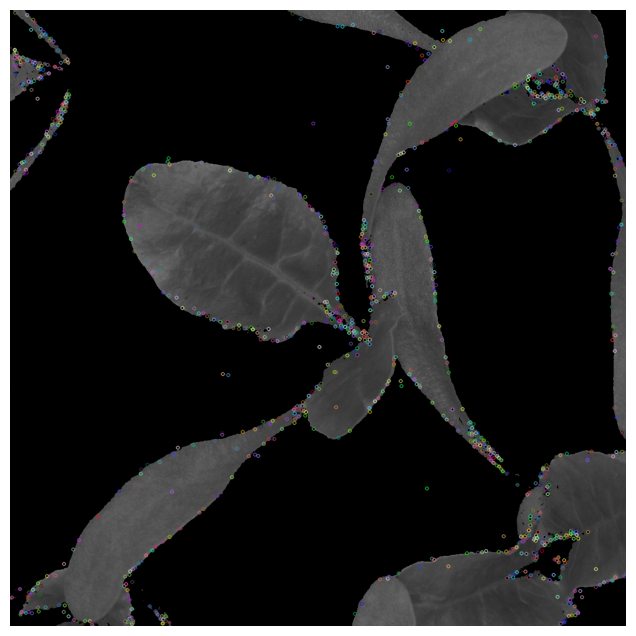

CPU times: total: 906 ms
Wall time: 549 ms


In [165]:
%%time

## TEST SIFT
sift = cv2.SIFT_create()

img_extracted_gray = cv2.cvtColor(img_extracted, cv2.COLOR_BGR2GRAY)

kp = sift.detect(img_extracted_gray, None)   #  找到关键点

# 绘制关键点 
img_kp_gray = cv2.drawKeypoints(img_extracted_gray, kp, img_extracted_gray)

# 计算关键点对应的sift特征向量
# kp为关键点列表，des为numpy的数组，为 (关键点数目,128)
kp, des = sift.compute(img_kp_gray, kp)

print('kp[0] =', kp[0])
print('len(kp) =', len(kp))
print('des.shape =', des.shape)

plt.figure(figsize=(8,8))
plt.imshow(img_kp_gray)
plt.axis('off')
plt.show()

In [166]:
%%time

# 获取 SIFT 特征列表
feature_sift_list = sift_feature(all_images)

100%|██████████| 978/978 [00:50<00:00, 19.41it/s]

CPU times: total: 1min 39s
Wall time: 50.4 s


In [167]:
print(len(feature_sift_list))     # 500
print(feature_sift_list[0])
print()

# 以下3个输出为sift特征的 shape, 为 (关键点数量, 128)
print(feature_sift_list[0].shape)      # (?, 128)
print(feature_sift_list[1].shape)      # (?, 128)
print(feature_sift_list[100].shape)    # (?, 128)

978
[[  0.   0.   0. ...   1.   0.   0.]
 [ 37. 113.  48. ...   0.   0.   1.]
 [  0.   0.   0. ...  55.   0.   0.]
 ...
 [  9.   0.   0. ...   0.   0.   0.]
 [  1.   0.   0. ...   0.   0.   0.]
 [  1.   0.   0. ...   0.   0.   0.]]

(113, 128)
(903, 128)
(753, 128)


In [168]:
## Initialize BOW Trainer

def bow_init(feature_sift_list):
    """Initialize BOW trainer"""
    
    ## 创建BOW训练器，指定 k-means 参数 k 把处理好的特征数据全部合并，利用聚类把特征词分为若干类，
    ## 此若干类的数目由自己设定，每一类相当于一个视觉词汇
    bow_kmeans_trainer = cv2.BOWKMeansTrainer(100)    # 100 个词汇
    
    for feature_sift in feature_sift_list:
        bow_kmeans_trainer.add(feature_sift)
    
    # 进行k-means聚类，返回词汇字典 也就是聚类中心
    voc = bow_kmeans_trainer.cluster()
    
    # 输出词汇字典
    print("In bow_init(), print variable `voc`: ")
    print(type(voc), voc.shape)    # <class 'numpy.ndarray'> (100, 128)
    print(voc)
    print()
    
    # FLANN 匹配  
    # algorithm 用来指定匹配所使用的算法，可以选择的有 LinearIndex、KTreeIndex、KMeansIndex、CompositeIndex 和 AutotuneIndex
    # 这里选择的是 KTreeIndex (使用 kd树 实现最近邻搜索)
    flann_params = dict(algorithm=1, tree=5)           # define parameters for cv2.FlannBasedMatcher()
    flann = cv2.FlannBasedMatcher(flann_params,{})
    
    print(flann)
    
    #初始化 bow 提取器(设置词汇字典),用于提取每一张图像的BOW特征描述
    # sift = cv2.xfeatures2d.SIFT_create()   # old-version cv2
    sift = cv2.SIFT_create()
    bow_img_descriptor_extractor = cv2.BOWImgDescriptorExtractor(sift, flann)        
    bow_img_descriptor_extractor.setVocabulary(voc)
    
    print(bow_img_descriptor_extractor)
    
    return bow_img_descriptor_extractor

In [169]:
## Extract BOW Features
def bow_feature(bow_img_descriptor_extractor, all_images):
    # 分别对每个图片提取BOW特征，获得BOW特征列表
    feature_bow_list = []
    
    # sift = cv2.xfeatures2d.SIFT_create()   # old-version cv2
    sift = cv2.SIFT_create()
    for i in tqdm(range(len(all_images))):
        image = cv2.cvtColor(all_images[i], cv2.COLOR_BGR2GRAY)
        feature_bow = bow_img_descriptor_extractor.compute(image,sift.detect(image))
        feature_bow_list.append(feature_bow)
        
    return np.array(feature_bow_list)[:,0,:]

In [170]:
%%time
## 获取 SIFT + BOW 特征

# 从图像中提取并保存在npy文件中
bow_extractor = bow_init(feature_sift_list)
all_feature_bow = bow_feature(bow_extractor, all_images)  # shape = (5544, 100)
# save_feature(all_feature_bow, 'all_feature_bow')

In bow_init(), print variable `voc`: 
<class 'numpy.ndarray'> (100, 128)
[[34.596985  82.50616   34.22227   ...  3.4317663  3.4796896  6.9484253]
 [67.28711   14.956641   2.2789063 ...  8.5546875  5.2191405  8.5546875]
 [ 4.664202   3.2790365  2.7471976 ... 36.53136    3.2494633  3.9682803]
 ...
 [16.364855   6.125033   3.8899398 ...  3.4187026  4.105595   3.9608617]
 [12.344672  10.487295  11.054508  ...  8.639754   9.206967  10.318033 ]
 [ 1.9271058  1.1284258  1.7514708 ... 18.62735    0.8912326  2.203903 ]]

< cv2.FlannBasedMatcher 0000026B0A383450>
< cv2.BOWImgDescriptorExtractor 0000026B0A3ABD30>


100%|██████████| 978/978 [01:34<00:00, 10.36it/s]

CPU times: total: 9min 32s
Wall time: 2min 40s


## HOG特征提取

In [171]:
# 所有图片 resize 成(128,128)，保证每个图像提取出的 HOG，LBP 特征数量一致
# 提取 HOG，LBP 特征前调用
all_images = resize_imgs(all_images)

In [172]:
# 提取 HOG 特征
def hog_feature(all_images):
    feature_hog_list = []
    for i in tqdm(range(len(all_images))):  # ft is short for skimage.feature
        feature_hog = ft.hog(all_images[i], 
                             orientations=16, 
                             pixels_per_cell=(32, 32), 
                             cells_per_block=(3, 3), 
                             feature_vector=True, 
                             channel_axis=-1 
                              )
        feature_hog_list.append(feature_hog)
    
    return np.array(feature_hog_list)

In [173]:
%%time

## 获取 HOG 特征
## 从图像中提取并保存在 csv 文件中
all_feature_hog = hog_feature(all_images)

# print('all_feature_hog.shape =', all_feature_hog.shape)
# save_feature(all_feature_hog, 'all_feature_hog')

100%|██████████| 978/978 [00:03<00:00, 305.29it/s]

CPU times: total: 3.14 s
Wall time: 3.21 s


176400


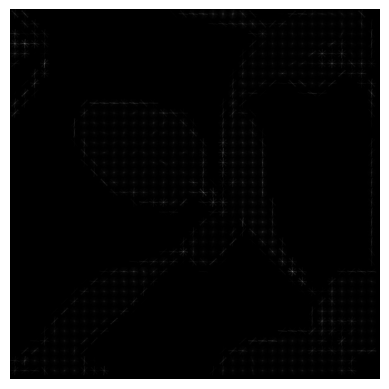

In [174]:
# TEST HOG
feature_hog = ft.hog(img_extracted, 
                     orientations=16, 
                     pixels_per_cell=(32, 32), 
                     cells_per_block=(3, 3), 
                     feature_vector=True,
                     channel_axis=-1 , 
                     visualize=True)
print(feature_hog[0].shape[0])
plt.imshow(feature_hog[1], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

### LBP特征提取

In [175]:
# 提取 LBP 特征
def lbp_feature(all_images):
    feature_lbp_list = []
    for j in tqdm(range(len(all_images))):
        feature_lbp = []
        image = all_images[j]
        for i in range(3):
            feature_lbp.append(ft.local_binary_pattern(np.array(image[:,:,i]), 64, 64, 'var'))
        feature_lbp_list.append(feature_lbp)
    return np.array(feature_lbp_list)

In [176]:
%%time

## 获取 LBP 特征
all_feature_lbp = lbp_feature(all_images)    # shape = (5544, 3, 128, 128)
print(np.array(all_feature_lbp).shape)        # (5544, 3, 128, 128)



## 将四维转为二维
all_feature_lbp = all_feature_lbp.reshape(all_feature_lbp.shape[0], 
                                          all_feature_lbp.shape[1] * all_feature_lbp.shape[2] * all_feature_lbp.shape[3])

print('all_feature_lbp.shape =', all_feature_lbp.shape)  # (5544, 49152)

100%|██████████| 978/978 [01:01<00:00, 15.86it/s]


(978, 3, 128, 128)
all_feature_lbp.shape = (978, 49152)
CPU times: total: 1min 1s
Wall time: 1min 1s


In [177]:
# TEST LBP
feature_lbp = []
for i in range(3):
    feature_lbp.append(ft.local_binary_pattern(img_extracted[:,:,i], 64, 64, 'var'))
print(feature_lbp)    # list of ndarray
print()

feature_lbp_array = np.array(feature_lbp)
print(feature_lbp_array.shape)

# 挑选出非 nan 值
feature_lbp_array[np.logical_not(np.isnan(feature_lbp_array))]

[array([[12.25278325, 12.00978633,  9.28115667, ..., 15.00183154,
         3.84866402,  7.22644648],
       [23.08247782, 18.13085798,  6.8945109 , ..., 19.13440484,
        10.44326994,  3.90661137],
       [13.79351821, 13.72981641,  9.48504877, ..., 15.85277504,
         8.01060406,  4.94377622],
       ...,
       [17.63608888, 14.39376598, 16.93167543, ...,         nan,
                nan,         nan],
       [17.64059174, 13.62535881, 17.12007179, ...,         nan,
                nan,         nan],
       [14.32681778,  9.43908623,  8.56781557, ...,         nan,
                nan,         nan]]), array([[228.02992634, 240.44821448, 220.74706795, ..., 536.00619226,
        477.64579805, 503.61833048],
       [290.02669534, 268.56728397, 232.37213905, ..., 635.09278182,
        545.43666343, 497.0242142 ],
       [236.14346192, 204.00537515, 227.27848229, ..., 622.56649763,
        560.98203494, 551.54174826],
       ...,
       [486.68709154, 474.933379  , 466.16965178, ..., 

array([ 12.25278325,  12.00978633,   9.28115667, ...,  99.05261109,
       105.21740086,   1.74529196])

## 特征处理

### 缺失值填补

In [178]:
## 填充缺失值
all_feature_lbp = fill_missing(all_feature_lbp)  
# save_feature(all_feature_lbp, 'all_feature_lbp')
# all_feature_lbp

### 标准化

In [179]:
%%time
all_feature_bow_normal = normalize(all_feature_bow)
save_feature(all_feature_bow_normal, 'all_feature_bow_normal')

all_feature_hog_normal = normalize(all_feature_hog)
save_feature(all_feature_hog_normal, 'all_feature_hog_normal')

all_feature_lbp_normal = normalize(all_feature_lbp)
save_feature(all_feature_lbp_normal, 'all_feature_lbp_normal')

all_feature_bow_normal.npy 文件已生成！
all_feature_hog_normal.npy 文件已生成！
all_feature_lbp_normal.npy 文件已生成！
CPU times: total: 781 ms
Wall time: 1.42 s


### 特征降维

In [180]:
%%time

print('all_feature_bow.shape =', all_feature_bow.shape)    # all_feature_hog.shape = (4750, 100)
pca_feature_bow = dimensionalityReduction(all_feature_bow, 100)
print('pca_feature_bow.shape =', pca_feature_bow.shape)    # pca_feature_hog.shape = (4750, 100)
save_feature(pca_feature_bow, 'pca_feature_bow')

all_feature_bow.shape = (978, 100)
0.19219911098480225
0.31616196036338806
0.4021487981081009
0.4646375887095928
0.5022734552621841
0.52905716560781
0.5538325738161802
0.5763597581535578
0.5962681714445353
0.6145522948354483
0.630491616204381
0.645830137655139
0.6597486343234777
0.673217298462987
0.685539954341948
0.6967749027535319
0.7077321344986558
0.7184608913958073
0.7286999393254519
0.7385958787053823
0.7482592239975929
0.7570287091657519
0.765285431407392
0.7733720494434237
0.781264160759747
0.7887862608768046
0.7961238664574921
0.8032039692625403
0.8100229427218437
0.8163608917966485
0.822602373547852
0.8284611073322594
0.8342053447850049
0.8398696430958807
0.845214607194066
0.8505327147431672
0.8556217518635094
0.8604260836727917
0.8651564414612949
0.8697398235090077
0.8742025173269212
0.878589665517211
0.8829272529110312
0.8871439448557794
0.891258955001831
0.8953109448775649
0.899183087516576
0.9029770190827549
0.9066909065004438
0.910375117789954
0.9139502318575978
0.917441

In [181]:
%%time

print('all_feature_hog.shape =', all_feature_hog.shape)    # all_feature_hog.shape = (5544, 576)
pca_feature_hog = dimensionalityReduction(all_feature_hog, 100)
print('pca_feature_hog.shape =', pca_feature_hog.shape)    # pca_feature_hog.shape = (5544, 100)
save_feature(pca_feature_hog, 'pca_feature_hog')

all_feature_hog.shape = (978, 576)
0.15356468500539366
0.27548143225339056
0.34100107004536884
0.4020071574863581
0.45463219402828026
0.4976788972584018
0.5263308761511538
0.5515036241816602
0.5745267121060031
0.5954868731577921
0.6148385171551591
0.6308148468302485
0.6459813997254021
0.6605698840614396
0.6739682430158327
0.686582475882468
0.6978155808430352
0.7083746729250536
0.718397181336655
0.7280795598259178
0.7374045792864378
0.7459878033284141
0.7542862366105839
0.7624244495226131
0.7701496785233516
0.7771293367737686
0.7836611799466874
0.7898126868294294
0.7957299331780784
0.8014755859920347
0.807074548636538
0.8126637996905772
0.8179114345303024
0.8228156082579319
0.8276184275284739
0.8322989819459841
0.8368779427464235
0.841391432133217
0.8457340649129792
0.8498489993667946
0.8538420299094897
0.8575019573239614
0.861135100335806
0.8646429618440225
0.8679654569150627
0.8711747496036206
0.8743169825041721
0.8772745414166904
0.8801387838580647
0.8829185234993407
0.88553548061264

In [182]:
%%time

print('all_feature_lbp.shape =', all_feature_lbp.shape)  # all_feature_lbp.shape = (5544, 49152)
pca_feature_lbp = dimensionalityReduction(all_feature_lbp, 100, True)
print('pca_feature_lbp.shape =', pca_feature_lbp.shape)  # pca_feature_lbp.shape = (5544, 100)
save_feature(pca_feature_lbp, 'pca_feature_lbp')

all_feature_lbp.shape = (978, 49152)
0.549744741004327
0.647320924871099
0.7138916602382297
0.7540503808005931
0.7748099823272712
0.7904669800768367
0.8044745318761406
0.8163884504782201
0.8280168144188857
0.8391022197054163
0.847359033624419
0.8551426076014474
0.8613290970059498
0.8673924462601158
0.8727779694751069
0.8776483021923264
0.8817777164772439
0.8857555436477864
0.8892870044352381
0.8926948623240393
0.8957436489968872
0.898639340709208
0.9013825681848752
0.9038388087855848
0.9061692649422606
0.9082662092873249
0.9101196652575546
0.9118846955980526
0.9136231541686041
0.915154509939377
0.9166260066236519
0.9180538782253422
0.9194519979809399
0.9208208372015032
0.922146599727098
0.9234485894633653
0.9246619114099337
0.9258598654980774
0.9269607567963476
0.9280514688632515
0.9291154958138543
0.930149852089534
0.9311465073052021
0.9320971324686307
0.9330297981135974
0.9339048278738165
0.9347462105664529
0.9355588836565628
0.9363495251513027
0.9371333123957202
0.9379012258426405
0

## 特征连接

In [183]:
# 将 SIFT+BOW, HOG, LBP 三种特征矩阵拼合到一起
all_all_feature_list = [pca_feature_bow, pca_feature_hog, pca_feature_lbp]

all_all_feature = [[] for i in range(978)]

for feature in all_all_feature_list:
    all_all_feature = np.hstack((all_all_feature, feature))

print(all_all_feature.shape)
# all_all_feature

(978, 300)


特征提取后的训练集与测试分开

In [184]:
all_feature = all_all_feature[:500]
print(all_feature.shape)
print(all_feature)
# 提取剩下的行  
test_all_feature = all_all_feature[500:]
print(test_all_feature.shape)
test_all_feature
# all_all_feature_list

(500, 300)
[[ 0.06430753  0.00776105 -0.0807224  ... -0.17272704 -0.21101273
  -0.75605543]
 [ 0.10251063  0.01507539 -0.09820914 ...  0.24834178 -0.47341539
  -0.11572373]
 [ 0.13794978 -0.02038385  0.09694599 ...  0.12632714  0.33791259
   0.00576994]
 ...
 [-0.06792572 -0.04875861 -0.00473683 ... -0.4340874  -0.71980641
  -0.77035149]
 [-0.15989254 -0.16282785  0.01058418 ... -1.62157569 -1.39284859
  -0.49926601]
 [-0.05058966 -0.05028407  0.00341972 ... -2.92834542 -0.91364848
   1.18629368]]
(478, 300)


array([[-1.00175358e-01, -9.19509232e-02, -2.30165129e-03, ...,
         5.88512843e-01, -1.76019696e+00,  6.38540005e-01],
       [ 4.90200184e-02,  1.46260457e-02, -1.16487861e-01, ...,
        -2.03868608e-01, -3.22175099e-01,  1.45361957e-02],
       [ 1.03366077e-01,  1.33079970e-02, -3.95206101e-02, ...,
         4.27427288e-01,  3.98356033e-01,  3.18686398e-01],
       ...,
       [ 4.07239459e-02,  1.24910614e-02, -5.72407618e-03, ...,
         1.03864624e+00,  6.06728969e-01,  4.41489977e-01],
       [ 1.03682578e-01,  1.66026652e-02, -1.48548901e-01, ...,
        -2.85948836e-01, -9.96801687e-03,  1.00901258e-01],
       [-8.97360593e-02, -8.48538876e-02, -1.31201348e-04, ...,
        -2.65060336e-02,  3.51953796e-01, -1.10307071e+00]])

In [185]:
np.save(feature_dir + 'all_feature', all_feature, allow_pickle=True)

In [186]:
# len(all_feature)

# 模型训练

## StratifiedShuffleSplit() 

**train_test_split()** 函数划分数据集是将所有数据同一划分训练集和验证集，这大概率会导致每一类数据在训练集和验证集的比例是不同的，数据集划分不平衡会导致训练模型时对于某一类的训练效果很好，而对另一类的训练效果很差，即出现了过拟合和欠拟合的情况。

<br>

**StratifiedShuffleSplit()** 函数将数据集“按类”划分训练集和验证集，保证每一类训练集和验证集的比例是相同的，有效降低了过拟合和欠拟合情况的出现。

In [187]:
# 按类划分数据集
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(all_feature, all_label)
for train_index, test_index in sss.split(all_feature, all_label):
    x_train, x_val = all_feature[train_index], all_feature[test_index]
    y_train, y_val = all_label[train_index], all_label[test_index]

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val  : ", x_val.shape)
print("y_val  : ", y_val.shape)

x_train:  (400, 300)
y_train:  (400,)
x_val  :  (100, 300)
y_val  :  (100,)


In [188]:
num_class_train = np.zeros(5, dtype=np.int64)
num_class_val = np.zeros(5, dtype=np.int64)
for y in y_train:
    num_class_train[y] += 1
for y in y_val:
    num_class_val[y] += 1
    
print('划分后训练集中各类的数量 =', num_class_train)
print('数据集中各类的数量 * 0.8 =', [round((i * 0.8), 1) for i in num_per_class.values()])
print('划分后验证集中各类的数量 =', num_class_val)
print('数据集中各类的数量 * 0.2 =', [round((i * 0.2), 1) for i in num_per_class.values()])

划分后训练集中各类的数量 = [80 80 80 80 80]
数据集中各类的数量 * 0.8 = [80.0, 80.0, 80.0, 80.0, 80.0]
划分后验证集中各类的数量 = [20 20 20 20 20]
数据集中各类的数量 * 0.2 = [20.0, 20.0, 20.0, 20.0, 20.0]


## 训练

### category_show()：各类信息展示

In [189]:
# 展示各类的准确率、召回率、f1-score，及混淆矩阵可视化
def category_show(model, x_val, y_val):
    target_names = ['Black-grass','Common wheat','Loose Silky-bent','Scentless Mayweed','Sugar beet']
    y_pred = model.predict(x_val)
    
    print(classification_report(y_val, y_pred, target_names=target_names))
    cm = confusion_matrix(y_val, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()

### XGBoost 模型

In [190]:
%%time

# XGBoost 模型
model_xgb = XGBClassifier(# objective="multi:softmax",
                          objective='multi:softproba',
                          n_estimators=1000,
                          num_class=5,
                          learning_rate=0.1,
                          # tree_method='gpu_hist', 
                          # gpu_id=-1,
                          max_depth=3, 
                          min_child_weight=2, 
                          max_delta_step=3, 
                          subsample=0.7, 
                          gamma=0, 
                          n_jobs=-1,)

model_xgb.fit(x_train, y_train, 
              early_stopping_rounds=10, 
              eval_set=[(x_val, y_val)], 
              eval_metric='mlogloss', 
              verbose=50)
score_xgb = model_xgb.score(x_val, y_val)
print('score_xgb =', score_xgb)

[0]	validation_0-mlogloss:1.49690
[50]	validation_0-mlogloss:0.56043
[88]	validation_0-mlogloss:0.55027
score_xgb = 0.8
CPU times: total: 14.3 s
Wall time: 2.19 s


                   precision    recall  f1-score   support

      Black-grass       0.59      0.50      0.54        20
     Common wheat       0.84      0.80      0.82        20
 Loose Silky-bent       0.68      0.75      0.71        20
Scentless Mayweed       0.90      0.95      0.93        20
       Sugar beet       0.95      1.00      0.98        20

         accuracy                           0.80       100
        macro avg       0.79      0.80      0.80       100
     weighted avg       0.79      0.80      0.80       100



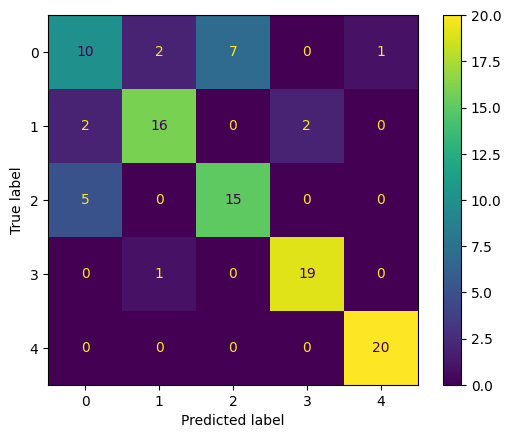

In [191]:
category_show(model_xgb, x_val, y_val)

### LightGBM 模型

In [192]:
%%time

# LightGBM 模型
model_lgb = lgb.LGBMClassifier(learning_rate=0.08, 
                               objective='multiclass', 
                               num_class=4, 
                               n_estimators=3000, 
                               max_depth=5, 
                               subsample=0.8, 
                               early_stopping_rounds=10,
                               verbose=10,
                               n_jobs=-1)
model_lgb.fit(
        x_train, y_train, 
        eval_set=[(x_val, y_val)],
       
        eval_metric='logloss',
        
)
score_lgb = model_lgb.score(x_val, y_val)
print('score_lgb =', score_lgb)

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000014 seconds, init for row-wise cost 0.001403 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40110
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 300
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[Light

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
                   precision    recall  f1-score   support

      Black-grass       0.59      0.50      0.54        20
     Common wheat       0.85      0.85      0.85        20
 Loose Silky-bent       0.70      0.70      0.70        20
Scentless Mayweed       0.90      0.95      0.93        20
       Sugar beet       0.91      1.00      0.95        20

         accuracy                           0.80       100
        macro avg       0.79      0.80      0.79       100
     weighted avg       0.79      0.80      0.79       100



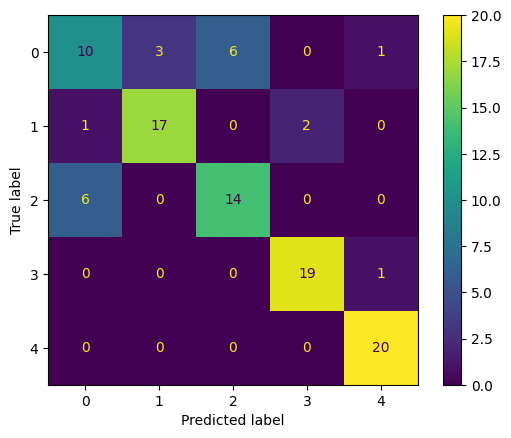

In [193]:
category_show(model_lgb, x_val, y_val)

### GBDT 模型

In [194]:
# %%time

# # GBDT模型
# model_gbdt = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, max_depth=3)
# model_gbdt.fit(x_train, y_train)
# score_gbdt = model_gbdt.score(x_val, y_val)
# print('score_gbdt =', score_gbdt)

score_gbdt = 0.78
CPU times: total: 3min 42s
Wall time: 3min 45s


                   precision    recall  f1-score   support

      Black-grass       0.47      0.35      0.40        20
     Common wheat       0.90      0.90      0.90        20
 Loose Silky-bent       0.57      0.65      0.60        20
Scentless Mayweed       0.95      1.00      0.98        20
       Sugar beet       0.95      1.00      0.98        20

         accuracy                           0.78       100
        macro avg       0.77      0.78      0.77       100
     weighted avg       0.77      0.78      0.77       100



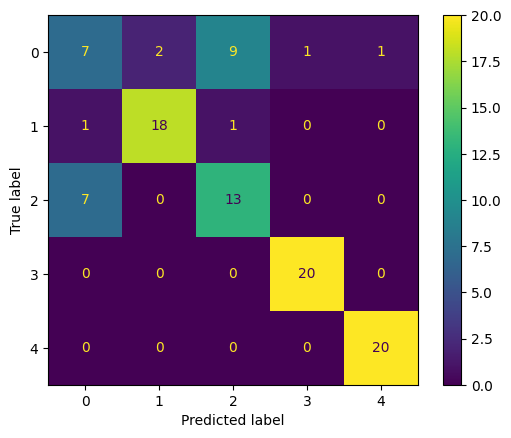

In [195]:
# category_show(model_gbdt, x_val, y_val)

### RandomForest 模型

In [196]:
%%time

# RandomForest 模型
model_rf = RandomForestClassifier(n_estimators=150, n_jobs=-1)
model_rf.fit(x_train, y_train)
score_rf = model_rf.score(x_val, y_val)
print('score_rf =', score_rf)

score_rf = 0.8
CPU times: total: 1.88 s
Wall time: 388 ms


                   precision    recall  f1-score   support

      Black-grass       0.64      0.45      0.53        20
     Common wheat       0.89      0.85      0.87        20
 Loose Silky-bent       0.68      0.75      0.71        20
Scentless Mayweed       0.83      0.95      0.88        20
       Sugar beet       0.91      1.00      0.95        20

         accuracy                           0.80       100
        macro avg       0.79      0.80      0.79       100
     weighted avg       0.79      0.80      0.79       100



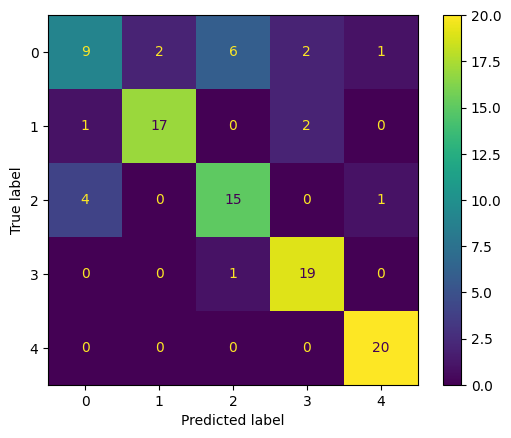

In [197]:
category_show(model_rf, x_val, y_val)

### SVC 模型

In [198]:
%%time

# SVC 模型
model_SVC = SVC(C=1)
model_SVC.fit(x_train, y_train)
score_SVC = model_SVC.score(x_val, y_val)
print('score_SVC =', score_SVC)

score_SVC = 0.54
CPU times: total: 31.2 ms
Wall time: 27 ms


                   precision    recall  f1-score   support

      Black-grass       0.43      0.65      0.52        20
     Common wheat       0.65      0.55      0.59        20
 Loose Silky-bent       0.50      0.15      0.23        20
Scentless Mayweed       0.48      0.80      0.60        20
       Sugar beet       0.79      0.55      0.65        20

         accuracy                           0.54       100
        macro avg       0.57      0.54      0.52       100
     weighted avg       0.57      0.54      0.52       100



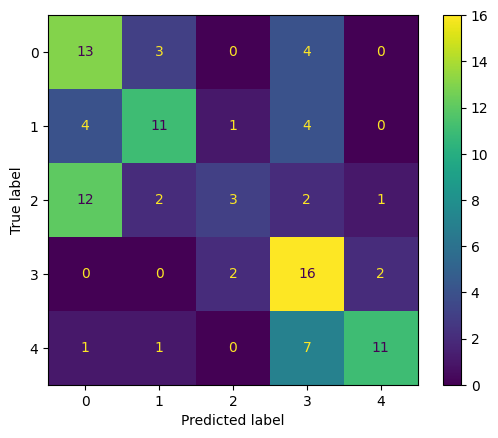

In [199]:
category_show(model_SVC, x_val, y_val)

### KNN 模型

In [200]:
model_knn = KNeighborsClassifier(n_neighbors=1)
model_knn.fit(x_train, y_train)
score_knn = model_knn.score(x_val, y_val)
print('score_knn =', score_knn)

score_knn = 0.29


                   precision    recall  f1-score   support

      Black-grass       0.15      0.20      0.17        20
     Common wheat       0.22      0.30      0.26        20
 Loose Silky-bent       0.23      0.40      0.29        20
Scentless Mayweed       1.00      0.15      0.26        20
       Sugar beet       0.89      0.40      0.55        20

         accuracy                           0.29       100
        macro avg       0.50      0.29      0.31       100
     weighted avg       0.50      0.29      0.31       100



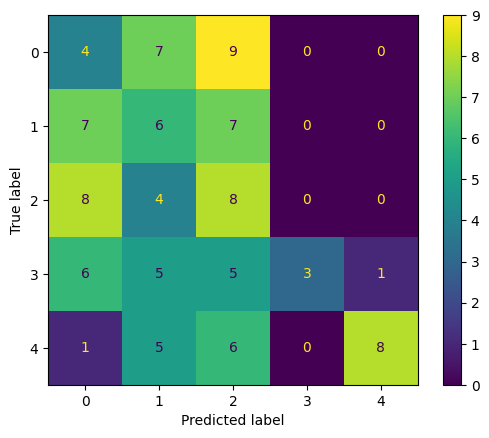

In [201]:
category_show(model_knn, x_val, y_val)

### SGD 模型

In [202]:
%%time

model_sgdc = SGDClassifier(max_iter=1000, tol=1e-3)
model_sgdc.fit(x_train, y_train)
score_sgdc = model_sgdc.score(x_val, y_val)
print('score_sgdc =', score_sgdc)

score_sgdc = 0.5
CPU times: total: 46.9 ms
Wall time: 29.8 ms


                   precision    recall  f1-score   support

      Black-grass       0.26      0.35      0.30        20
     Common wheat       0.54      0.65      0.59        20
 Loose Silky-bent       0.18      0.15      0.16        20
Scentless Mayweed       0.93      0.65      0.76        20
       Sugar beet       0.78      0.70      0.74        20

         accuracy                           0.50       100
        macro avg       0.54      0.50      0.51       100
     weighted avg       0.54      0.50      0.51       100



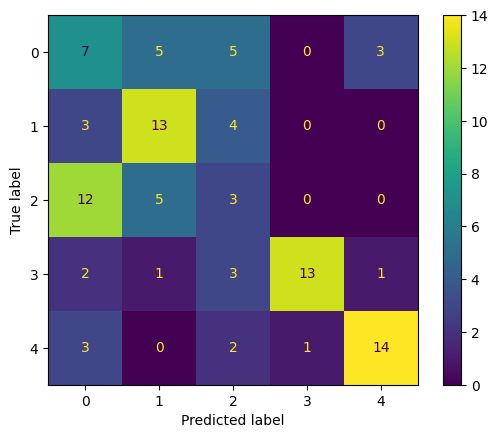

In [203]:
category_show(model_sgdc, x_val, y_val)

### ExtraTrees 模型

In [204]:
model_ET = ExtraTreesClassifier()
model_ET.fit(x_train, y_train)
score_ET = model_ET.score(x_val, y_val)
print('score_ET =', score_ET)

score_ET = 0.72


                   precision    recall  f1-score   support

      Black-grass       0.50      0.50      0.50        20
     Common wheat       0.70      0.70      0.70        20
 Loose Silky-bent       0.69      0.55      0.61        20
Scentless Mayweed       0.76      0.95      0.84        20
       Sugar beet       0.95      0.90      0.92        20

         accuracy                           0.72       100
        macro avg       0.72      0.72      0.72       100
     weighted avg       0.72      0.72      0.72       100



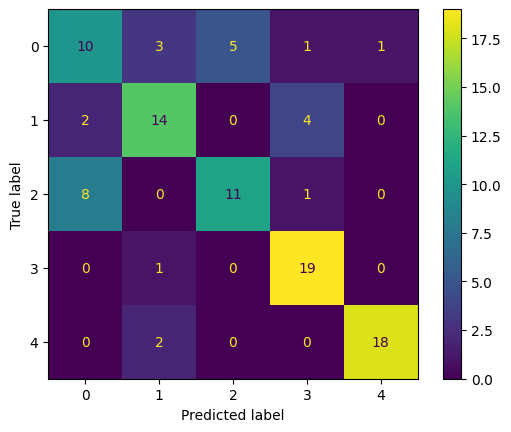

In [205]:
category_show(model_ET, x_val, y_val)

### 集成

In [206]:
%%time

estimators = [('rf', model_rf),
              ('SVC', model_SVC),
              ('SGDC', model_sgdc),
              ('ET', model_ET)
             ]

model_stack = StackingClassifier(estimators=estimators, 
                                 final_estimator= XGBClassifier(learning_rate=0.1, 
                                                                # objective='multi:softmax',
                                                                objective='multi:softproba',
                                                                num_class=5, 
                                                                n_estimators=500, 
                                                                # tree_method='gpu_hist', 
                                                                # gpu_id=0, 
                                                                max_depth=3, 
                                                                min_child_weight=3, 
                                                                max_delta_step=3, 
                                                                subsample=0.7, 
                                                                gamma=0, 
                                                                n_jobs=-1, 
                                                                use_label_encoder=False)
                                )

model_stack.fit(x_train, y_train)

score_stack = model_stack.score(x_val, y_val)
print('score_stack =', score_stack)

score_stack = 0.77
CPU times: total: 8.23 s
Wall time: 7.59 s


# 测试集预测与输出


In [207]:
#模型预测
predict_test = model_stack.predict(test_all_feature)
#字典转换为类名
num_to_class_dict = dict(zip(classes_dict.values(), classes_dict.keys()))

In [208]:
predict_test

array([4, 1, 2, 2, 3, 0, 2, 0, 4, 2, 3, 4, 3, 4, 0, 1, 1, 4, 1, 4, 3, 3,
       2, 2, 0, 2, 0, 3, 0, 3, 1, 4, 3, 2, 0, 2, 2, 4, 4, 3, 1, 3, 2, 2,
       2, 0, 4, 3, 2, 1, 0, 1, 3, 3, 2, 4, 4, 1, 3, 3, 3, 0, 0, 1, 0, 3,
       3, 1, 2, 0, 2, 2, 4, 0, 0, 0, 1, 2, 3, 0, 4, 0, 3, 0, 3, 4, 3, 4,
       0, 2, 0, 3, 3, 4, 3, 0, 4, 3, 3, 2, 3, 0, 4, 4, 3, 0, 0, 4, 4, 3,
       4, 1, 0, 0, 2, 3, 0, 3, 0, 1, 0, 2, 0, 3, 2, 1, 3, 2, 4, 3, 0, 0,
       3, 1, 0, 3, 4, 4, 0, 2, 2, 2, 2, 0, 2, 1, 0, 0, 4, 0, 4, 3, 0, 3,
       4, 4, 0, 0, 3, 2, 1, 3, 1, 3, 4, 0, 3, 2, 3, 0, 2, 1, 2, 2, 2, 2,
       4, 0, 0, 3, 4, 2, 4, 3, 3, 3, 1, 0, 1, 2, 0, 2, 0, 0, 2, 4, 0, 0,
       0, 2, 0, 0, 1, 0, 3, 4, 4, 2, 4, 2, 3, 3, 4, 3, 3, 3, 4, 1, 4, 2,
       0, 0, 0, 3, 4, 1, 0, 2, 3, 4, 4, 0, 0, 3, 2, 3, 4, 3, 4, 1, 2, 0,
       0, 0, 3, 4, 2, 3, 0, 0, 3, 3, 0, 4, 2, 4, 3, 4, 3, 0, 4, 0, 4, 2,
       4, 0, 4, 3, 3, 1, 4, 2, 1, 3, 0, 0, 3, 4, 2, 2, 3, 2, 4, 1, 3, 2,
       2, 3, 3, 4, 0, 4, 1, 1, 4, 2, 4, 1, 4, 3, 3,

In [209]:
print(test_all_feature.shape)
test_all_feature

(478, 300)


array([[-1.00175358e-01, -9.19509232e-02, -2.30165129e-03, ...,
         5.88512843e-01, -1.76019696e+00,  6.38540005e-01],
       [ 4.90200184e-02,  1.46260457e-02, -1.16487861e-01, ...,
        -2.03868608e-01, -3.22175099e-01,  1.45361957e-02],
       [ 1.03366077e-01,  1.33079970e-02, -3.95206101e-02, ...,
         4.27427288e-01,  3.98356033e-01,  3.18686398e-01],
       ...,
       [ 4.07239459e-02,  1.24910614e-02, -5.72407618e-03, ...,
         1.03864624e+00,  6.06728969e-01,  4.41489977e-01],
       [ 1.03682578e-01,  1.66026652e-02, -1.48548901e-01, ...,
        -2.85948836e-01, -9.96801687e-03,  1.00901258e-01],
       [-8.97360593e-02, -8.48538876e-02, -1.31201348e-04, ...,
        -2.65060336e-02,  3.51953796e-01, -1.10307071e+00]])

In [210]:
#ID列名称获取
img_names = os.listdir("C:/Users/ymh33/Desktop/MachineLearning/ClassDesign/test1/new_plant/new_plant/test/")


In [211]:
#预测结果列生成
predict_class = []
for pred in predict_test:
    predict_class.append(num_to_class_dict[pred])
# predict_class

In [212]:
#转换为df
df_submission = pd.DataFrame()
df_submission['ID'] = img_names
df_submission['Category'] =predict_class

In [213]:
df_submission.head()

,ID,Category
0,abkieurfrr.png,Sugar beet
1,ablzkpojla.png,Common wheat
2,acmbgjflct.png,Loose Silky-bent
3,afhcnytjtd.png,Loose Silky-bent
4,ahjnndkxft.png,Scentless Mayweed


In [214]:
df_submission.to_csv("C:/Users/ymh33/Desktop/MachineLearning/ClassDesign/test1/submission4.csv", index=False)


